# WildfireSpreadTS Embeddings Exploration

This notebook explores the CNN embeddings extracted from WildfireSpreadTS imagery.

**Embeddings Info:**
- Source: ResNet50 pretrained on ImageNet
- Dimension: 2048 features per image
- Format: Parquet file with embeddings + metadata

**Goals:**
1. Understand embedding structure and dimensions
2. Analyze embedding statistics and distributions
3. Explore metadata (dates, event IDs, filenames)
4. Check data quality (missing values, duplicates)
5. Visualize embedding patterns


In [1]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set paths
PROJECT_ROOT = Path().resolve().parent
INTERIM_DIR = PROJECT_ROOT / "data" / "interim"
EMBEDDINGS_PATH = INTERIM_DIR / "wildfirespreadts_embeddings.parquet"

print(f"Embeddings path: {EMBEDDINGS_PATH}")
print(f"File exists: {EMBEDDINGS_PATH.exists()}")


Embeddings path: C:\Users\muron\Documents\ml-wildfire-risk-predictor\data\interim\wildfirespreadts_embeddings.parquet
File exists: True


## 1. Load Embeddings


In [2]:
# Load embeddings
if EMBEDDINGS_PATH.exists():
    print("Loading embeddings...")
    df = pd.read_parquet(EMBEDDINGS_PATH)
    print(f"✓ Loaded {len(df):,} rows")
    print(f"✓ {len(df.columns)} columns")
else:
    print(f"⚠️  Embeddings file not found: {EMBEDDINGS_PATH}")
    print("Please run: python src/data/extract_cnn_embeddings.py")


Loading embeddings...
✓ Loaded 13,000 rows
✓ 2050 columns


## 2. Basic Structure


In [3]:
# Display basic info
print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nColumn types:")
print(df.dtypes.value_counts())

print(f"\n" + "="*70)
print("COLUMN NAMES")
print("="*70)
print(f"Total columns: {len(df.columns)}")
print(f"\nFirst 20 columns: {list(df.columns[:20])}")
print(f"\nLast 10 columns: {list(df.columns[-10:])}")


DATASET OVERVIEW
Shape: (13000, 2050)
Memory usage: 203.88 MB

Column types:
float64    2048
int64         1
object        1
Name: count, dtype: int64

COLUMN NAMES
Total columns: 2050

First 20 columns: ['sample_idx', 'split', 'embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7', 'embedding_8', 'embedding_9', 'embedding_10', 'embedding_11', 'embedding_12', 'embedding_13', 'embedding_14', 'embedding_15', 'embedding_16', 'embedding_17']

Last 10 columns: ['embedding_2038', 'embedding_2039', 'embedding_2040', 'embedding_2041', 'embedding_2042', 'embedding_2043', 'embedding_2044', 'embedding_2045', 'embedding_2046', 'embedding_2047']


In [4]:
# Separate metadata and embedding columns
embedding_cols = [c for c in df.columns if c.startswith('embedding_')]
metadata_cols = [c for c in df.columns if not c.startswith('embedding_')]

print(f"Embedding columns: {len(embedding_cols)}")
print(f"Metadata columns: {len(metadata_cols)}")
print(f"\nMetadata columns: {metadata_cols}")


Embedding columns: 2048
Metadata columns: 2

Metadata columns: ['sample_idx', 'split']


## Metadata


In [5]:
# Display metadata summary
print("="*70)
print("METADATA SUMMARY")
print("="*70)
print(df[metadata_cols].head(10))


METADATA SUMMARY
   sample_idx  split
0           0  train
1           1  train
2           2  train
3           3  train
4           4  train
5           5  train
6           6  train
7           7  train
8           8  train
9           9  train


In [ ]:
# Check split distribution if available
if 'split' in df.columns:
    print("Split distribution:")
    print(df['split'].value_counts())
else:
    print("No split column found")


No date column found


No event_id column found


## Embedding Statistics


In [9]:
# Extract embedding matrix
embedding_matrix = df[embedding_cols].values
print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Expected: ({len(df)}, 2048)")


Embedding matrix shape: (13000, 2048)
Expected: (13000, 2048)


In [ ]:
# Basic statistics
print("Embedding Statistics:")
print(f"  Min: {embedding_matrix.min():.4f}")
print(f"  Max: {embedding_matrix.max():.4f}")
print(f"  Mean: {embedding_matrix.mean():.4f}")
print(f"  Std: {embedding_matrix.std():.4f}")
print(f"\nSample dimensions (first 5):")
for i in range(min(5, len(embedding_cols))):
    col = embedding_cols[i]
    print(f"  {col}: mean={df[col].mean():.4f}, std={df[col].std():.4f}")


EMBEDDING STATISTICS
Min: 0.0000
Max: 7.0913
Mean: 0.2437
Std: 0.3794

Per-dimension statistics (first 10 dimensions):
  embedding_0: mean=0.0869, std=0.0881, min=0.0000, max=0.7644
  embedding_1: mean=0.4320, std=0.2895, min=0.0000, max=2.3414
  embedding_2: mean=0.0694, std=0.0933, min=0.0000, max=0.9280
  embedding_3: mean=0.1362, std=0.1355, min=0.0000, max=1.4486
  embedding_4: mean=0.0390, std=0.1021, min=0.0000, max=1.5899
  embedding_5: mean=0.2029, std=0.2441, min=0.0000, max=2.4062
  embedding_6: mean=0.4234, std=0.3220, min=0.0000, max=2.3514
  embedding_7: mean=0.2508, std=0.2138, min=0.0000, max=1.9805
  embedding_8: mean=0.1161, std=0.1166, min=0.0000, max=1.5732
  embedding_9: mean=0.0724, std=0.1040, min=0.0000, max=1.1377


In [11]:
# Check for missing values
missing = df[embedding_cols].isna().sum().sum()
print(f"Missing values in embeddings: {missing:,}")
if missing > 0:
    print("\nColumns with missing values:")
    missing_cols = df[embedding_cols].isna().sum()
    print(missing_cols[missing_cols > 0])
else:
    print("✓ No missing values in embeddings")


Missing values in embeddings: 0
✓ No missing values in embeddings


In [12]:
# Check for infinite values
inf_count = np.isinf(embedding_matrix).sum()
print(f"Infinite values: {inf_count:,}")
if inf_count > 0:
    print("⚠️  Warning: Found infinite values in embeddings")
else:
    print("✓ No infinite values")


Infinite values: 0
✓ No infinite values


## Visualizations


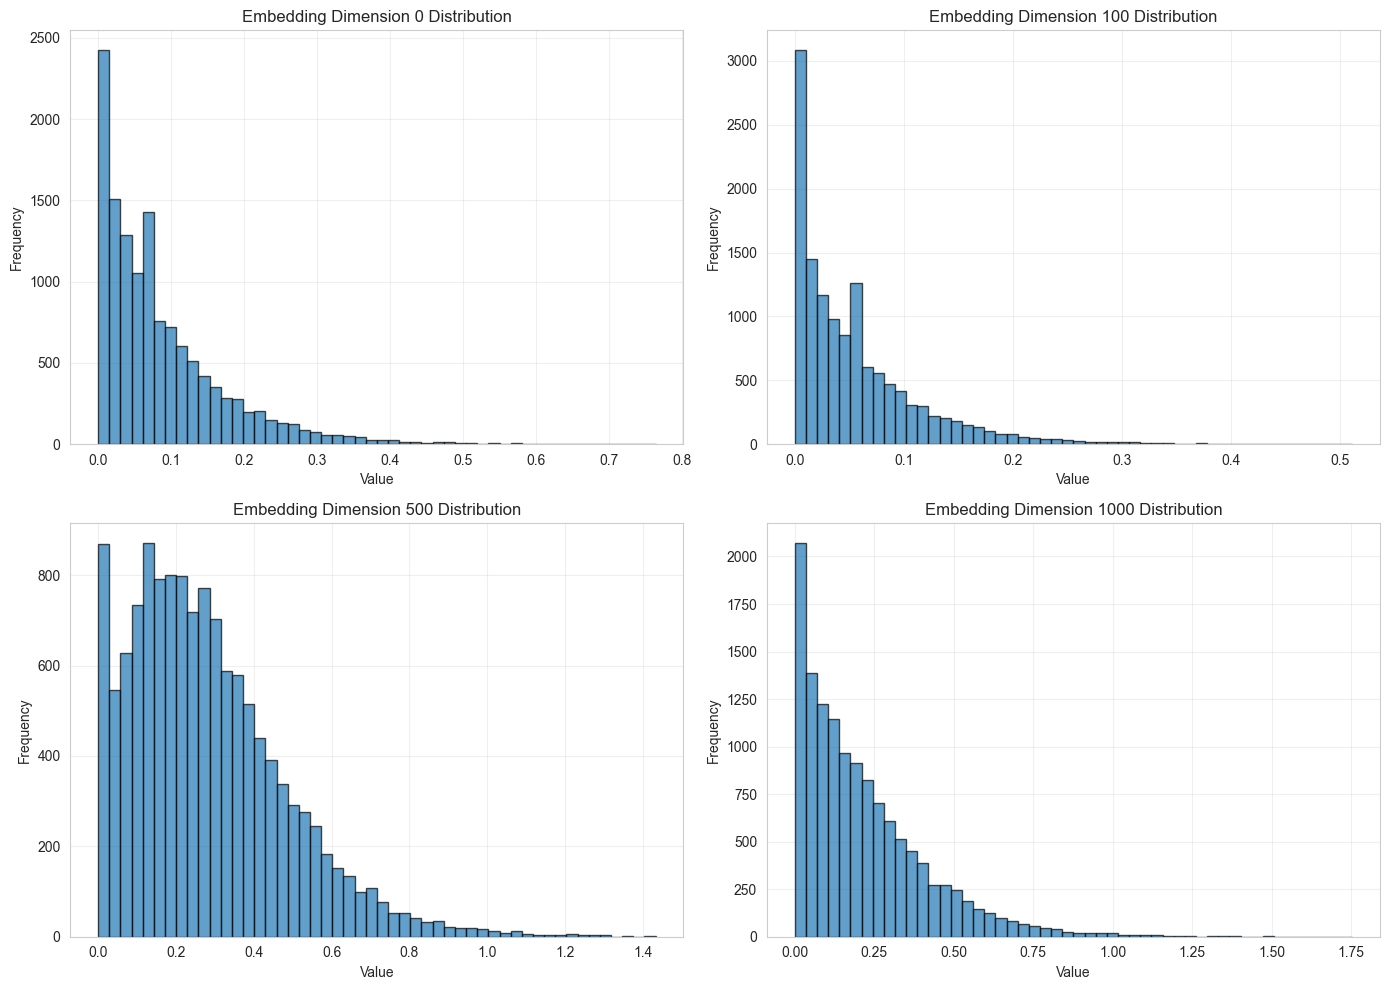

In [ ]:
# Sample embedding dimensions visualization
sample_dims = embedding_cols[:6]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(sample_dims):
    axes[i].hist(df[col], bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


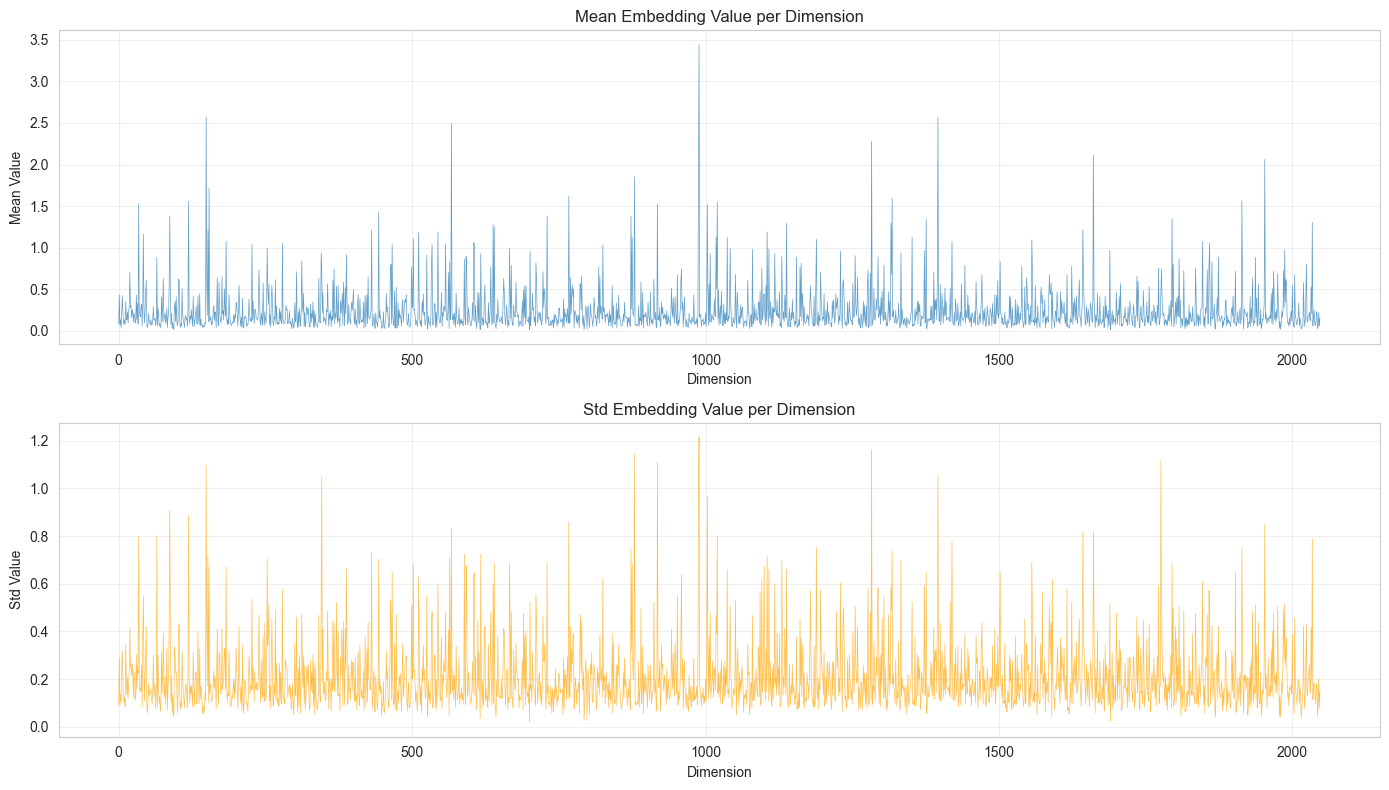

No date information available for visualization


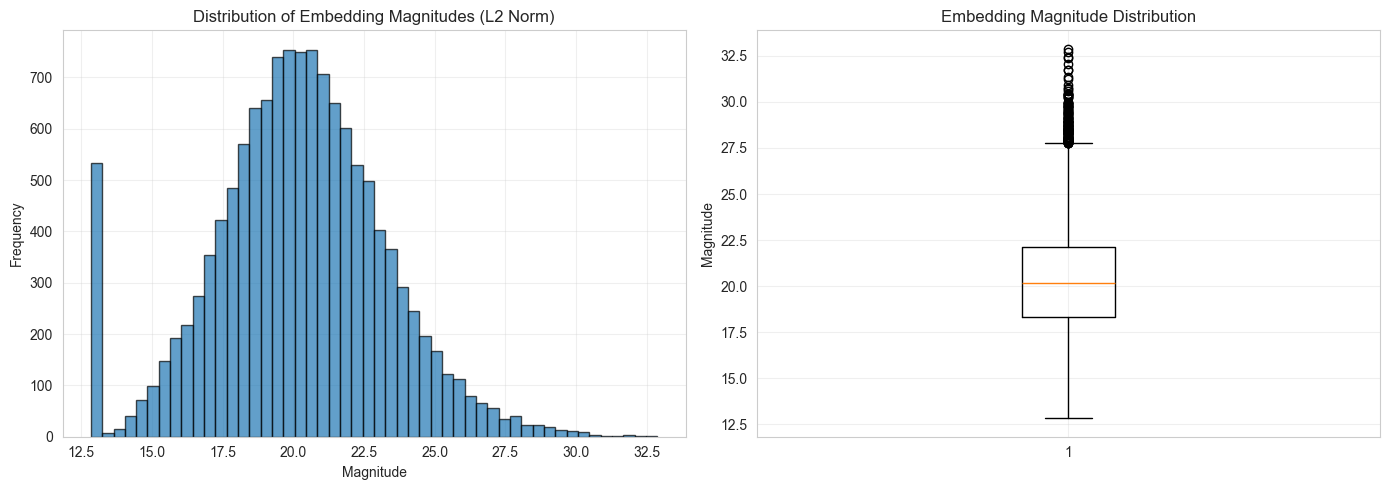

Magnitude statistics:
  Mean: 20.1701
  Std: 3.0989
  Min: 12.8355
  Max: 32.8779


In [16]:
# Embedding magnitude (L2 norm) distribution
embedding_norms = np.linalg.norm(embedding_matrix, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(embedding_norms, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of Embedding Magnitudes (L2 Norm)')
axes[0].set_xlabel('Magnitude')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(embedding_norms, vert=True)
axes[1].set_title('Embedding Magnitude Distribution')
axes[1].set_ylabel('Magnitude')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Magnitude statistics:")
print(f"  Mean: {embedding_norms.mean():.4f}")
print(f"  Std: {embedding_norms.std():.4f}")
print(f"  Min: {embedding_norms.min():.4f}")
print(f"  Max: {embedding_norms.max():.4f}")


## 6. Data Quality Checks


DATA QUALITY CHECKS
Duplicate rows: 0

Missing values in metadata:
  ✓ No missing values


EMBEDDING RANGE ANALYSIS
Values > 100: 0
Values < -100: 0

Zero values: 1,357,525 (5.10%)

✓ No constant dimensions


SAMPLE DATA (First 5 rows)
   sample_idx  split
0           0  train
1           1  train
2           2  train
3           3  train
4           4  train


In [20]:
# Sample embedding values (first row, first 20 dimensions)
print("="*70)
print("SAMPLE EMBEDDING VALUES (First row, first 20 dimensions)")
print("="*70)
sample_emb = df[embedding_cols[:20]].iloc[0]
print(sample_emb)


SAMPLE EMBEDDING VALUES (First row, first 20 dimensions)
embedding_0     0.017808
embedding_1     0.328060
embedding_2     0.083382
embedding_3     0.251513
embedding_4     0.012204
embedding_5     0.162902
embedding_6     0.164516
embedding_7     0.276921
embedding_8     0.008803
embedding_9     0.148420
embedding_10    0.033320
embedding_11    0.196437
embedding_12    0.020661
embedding_13    0.051946
embedding_14    0.081722
embedding_15    0.099170
embedding_16    0.266960
embedding_17    0.070652
embedding_18    0.468930
embedding_19    0.173079
Name: 0, dtype: float64


## 8. Summary


In [21]:
print("="*70)
print("EXPLORATION SUMMARY")
print("="*70)
print(f"\nDataset:")
print(f"  Total samples: {len(df):,}")
print(f"  Embedding dimensions: {len(embedding_cols)}")
print(f"  Metadata columns: {len(metadata_cols)}")
print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\nEmbeddings:")
print(f"  Shape: {embedding_matrix.shape}")
print(f"  Value range: [{embedding_matrix.min():.4f}, {embedding_matrix.max():.4f}]")
print(f"  Mean: {embedding_matrix.mean():.4f}")
print(f"  Std: {embedding_matrix.std():.4f}")
print(f"  Missing values: {df[embedding_cols].isna().sum().sum():,}")

if 'date' in df.columns and df['date'].notna().sum() > 0:
    print(f"\nTemporal coverage:")
    print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"  Years: {df['year'].nunique()}")
    print(f"  Unique dates: {df['date'].nunique():,}")

if 'event_id' in df.columns:
    print(f"\nEvents:")
    print(f"  Unique events: {df['event_id'].nunique():,}")
    print(f"  Images per event (mean): {df['event_id'].value_counts().mean():.2f}")

print(f"\n" + "="*70)
print("✓ Embeddings ready for feature preparation!")
print("  Next step: python src/data/prepare_wildfirespreadts_features.py")
print("="*70)


EXPLORATION SUMMARY

Dataset:
  Total samples: 13,000
  Embedding dimensions: 2048
  Metadata columns: 2
  Memory usage: 203.88 MB

Embeddings:
  Shape: (13000, 2048)
  Value range: [0.0000, 7.0913]
  Mean: 0.2437
  Std: 0.3794
  Missing values: 0

✓ Embeddings ready for feature preparation!
  Next step: python src/data/prepare_wildfirespreadts_features.py
